# Contrastive Learning
This example demonstrates how to implement a Contrastive Learning [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) using Contrastive Loss to determine whether a pair of images are similar. Contrastive Loss was introduced by Yann Le Cunn et al. in the paper ["Dimensionality Reduction by Learning an Invariant Mapping."](https://www.researchgate.net/publication/4246277_Dimensionality_Reduction_by_Learning_an_Invariant_Mapping).

[Knowledge source](https://www.youtube.com/watch?v=GikIJpUv6oo)

![Simese-network](./images/siamese-network.png)

In [61]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras

## Setup dataset

### Download dataset from keras dataset module

In [62]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train shape:", X_train.shape)
print("Y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


### Display images with their labels

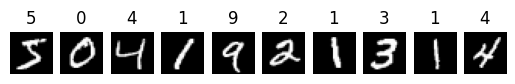

In [63]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

### Reshaping data into correct array

According to X_train shape, each image has `28 x 28` px dimension.

We want to create a neutral network that receives every pixel as an input. Reshaping data into single array will take 28 x 28 = '784' pixels.

![Shape input](./images/siamese-network-784.png)

In [64]:
image_array_size = 784
X_train = X_train.reshape(-1, image_array_size)
X_test = X_test.reshape(-1, image_array_size)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Image as array:", X_train[0])

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Image as array: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0 

### Normalize data

We now want to normalize the pixel values to a range between 0 and 1 (instead of 0 to 255).

> This approach is common because neural networks tend to perform better with smaller, normalized values. They prefer inputs scaled between 0 and 1, even if the relative differences remain the same.

We can use the min-max normalization formula for this:

![Normalize function](./images/normalize_function.png)

Here is what the code to implement this formula would look like:

    X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
For an image, X_train.min() is 0 and X_train.max() is 255, so we can simplify the formula to:

    X_train = X_train / 255.0

In [65]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Generate the pairs for training and testing the model:

We'll train a `Siamese Network` using positive and negative pairs of images. A positive pair consists of two images representing the same digit, while a negative pair consists of two images representing different digits.

In [66]:
import numpy as np


def generate_pairs(X, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image representing the same digit.
        # This is a positive pair.
        positive_digit_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[positive_digit_index]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same digit should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different digit.
        # This is a negative pair.
        negative_digit_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[negative_digit_index]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different digits should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [67]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


Display some of these pairs to ensure they were generated correctly:

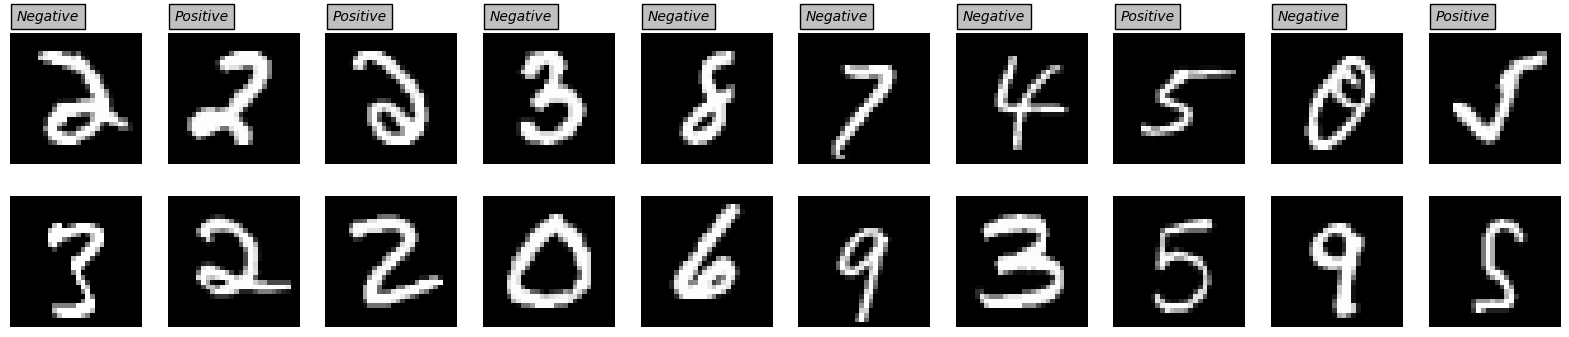

In [68]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pairs, y_train_pairs)

## Building Siamese Network

It's time to start building the [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network). Let's first define the inputs that will receive the pair of images:

In [69]:
from keras import Input

input1 = Input(shape=(image_array_size,))
input2 = Input(shape=(image_array_size,))

### Neuron network Siamese Network

Then, we can build the body of the Siamese Network. This network will be responsible of generating the embeddings for each of the input images:

![Embedding](./images/siamese-network-128.png)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential(
    [
        Input(shape=(image_array_size,)),
        Dense(512, activation="relu"), # (Rectified Linear Unit)
        Dense(256, activation="relu"),
        Dense(128, activation=None),
    ]
)

> IMAGE OF NEUTRAL NETWORK WITH HIGHLIGHT PHASE

Our network will have two branches, each one responsible for processing one of the images in the pair. We want to share the same weights between the branches, so we'll use the same network instance:

In [71]:
twin1 = network(input1)
twin2 = network(input2)

### Distance

The output of the Siamese Network will be the distance between the embeddings of the two images. To do this, we can use a `Lambda` layer to calculate the [`Euclidean distance`](https://en.wikipedia.org/wiki/Euclidean_distance) between the embeddings:

In [72]:
from keras.layers import Lambda
from keras.ops import norm


def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)


distance = Lambda(euclidean_distance)([twin1, twin2])

### Model setup

In [73]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

We'll use the Contrastive Loss to train the model. You can find the formula of this loss in the paper ["Dimensionality Reduction by Learning an Invariant Mapping."](https://www.researchgate.net/publication/4246277_Dimensionality_Reduction_by_Learning_an_Invariant_Mapping).

In [74]:
from keras.ops import cast, maximum, square


def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """

    margin = 1
    y = cast(y, d.dtype)

    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))

    return loss

Let's compile the model using the Contrastive Loss:

In [75]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

In [76]:
keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - binary_accuracy: 0.8947 - loss: 0.0512 - val_binary_accuracy: 0.9628 - val_loss: 0.0202
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - binary_accuracy: 0.9729 - loss: 0.0166 - val_binary_accuracy: 0.9675 - val_loss: 0.0173
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - binary_accuracy: 0.9818 - loss: 0.0119 - val_binary_accuracy: 0.9696 - val_loss: 0.0159
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - binary_accuracy: 0.9882 - loss: 0.0090 - val_binary_accuracy: 0.9689 - val_loss: 0.0157
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - binary_accuracy: 0.9911 - loss: 0.0074 - val_binary_accuracy: 0.9685 - val_loss: 0.0150
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - binary_accuracy: 0.9930 - loss: 0.0064 - val_binary_accuracy: 0.9700 - val_loss: 0.0145
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - binary_accuracy: 0.9940 - loss: 0.0055 - val_binary_accuracy: 0.96

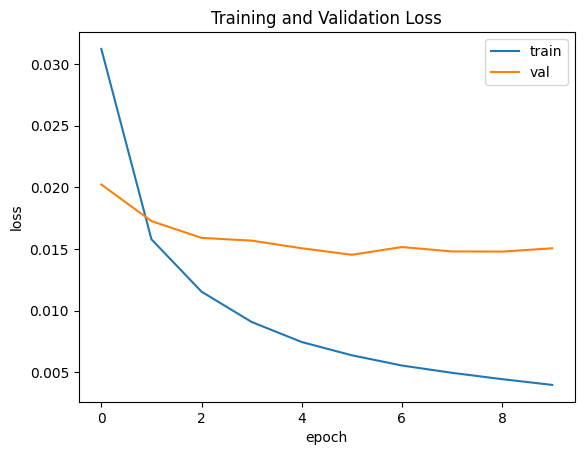

In [51]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

## Validation

Let's evaluate the model using the test data and display some of the predictions:

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


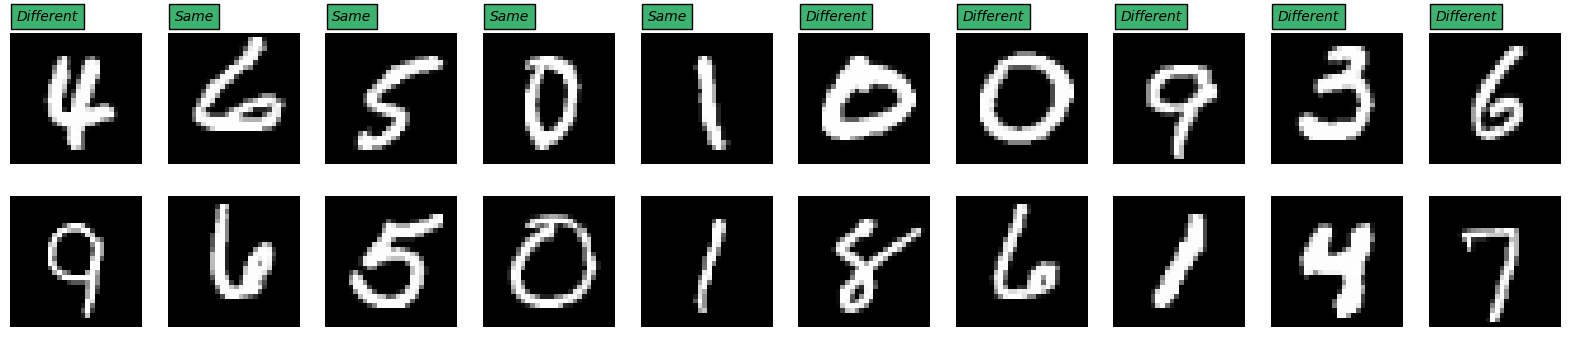

In [52]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
display_pairs(X_test_pairs, predictions, predictions == y_test_pairs)

### Accuracy

Finally, we can compute the accuracy of the model on the test data:

In [53]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().cpu().numpy():.2f}")

Accuracy: 0.97


### Model layers

These are the different layers of the model we trained:

In [54]:
model.layers

[<InputLayer name=input_layer_3, built=True>,
 <InputLayer name=input_layer_4, built=True>,
 <Sequential name=sequential_1, built=True>,
 <Lambda name=lambda_1, built=True>]

We can reference the sequential model to generate embeddings for new images:

In [55]:
embedding_model: Sequential = model.layers[2]

### Validate scenario

Let's select two random images representing the digit `3`, and one image representing the digit `7`:

In [56]:
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(np.int64(9821), np.int64(7804), np.int64(2513))

We can generate the embeddings for these `3` images:

In [57]:
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


#### Validate positive scenario

The distance between the embeddings of the two images representing the digit 3 should be really small (close to 0):

In [58]:
norm(embedding1 - embedding2).cpu().numpy()

array(0.02811843, dtype=float32)

#### Validate negative scenario

The distances between the embeddings of the images representing the digit 3 and the image representing the digit 7 should be large (close to 1):

In [59]:
norm(embedding1 - embedding3).cpu().numpy(), norm(embedding2 - embedding3).cpu().numpy()

(array(1.0119087, dtype=float32), array(0.9974372, dtype=float32))

## Save model

In [60]:
embedding_model.save("model/number_predictor.keras")